In [1]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import torch
import os
import shutil
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/export.csv')
df.head()

,drug_id,drug_name,synonyms,pathway_name,targets,pubchem
0,1259,Talazoparib,"BMN-673, BMN 973",Genome integrity,"PARP1, PARP2",44819241
1,1372,Trametinib,"GSK1120212, Mekinist",ERK MAPK signaling,"MEK1, MEK2",11707110
2,1559,Luminespib,"AUY922, VER-52296,NVP-AUY922, AUY",Protein stability and degradation,HSP90,10096043
3,1615,CZC24832,GTPL6653,PI3K/MTOR signaling,PI3Kgamma,42623951
4,1620,PFI3,"PFI-3, PFI 3, AOB2221",Chromatin other,"Polybromo 1, SMARCA4, SMARCA2",78243717


In [3]:
def readGeneticData(dataPath):
    df_Gen = pd.read_csv(dataPath)
    df_Gen['IS Mutated']=df_Gen['IS Mutated'].dropna()
    df_Gen['Recurrent Gain Loss']=df_Gen['Recurrent Gain Loss'].fillna('nan')
    df_Gen['Recurrent Gain Loss']=df_Gen['Recurrent Gain Loss'].map({'gain': 1, 'loss':0, 'nan': 3})
    return df_Gen
df_Gen = readGeneticData('data\PANCANCER_Genetic_features_Mon Feb 19 14_07_49 2024.csv')
df_Gen.head()

,Cell Line Name,COSMIC ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Genetic Feature,IS Mutated,Recurrent Gain Loss,Genes in Segment
0,CAL-29,1290730,urogenital_system,bladder,BLCA,CDC27_mut,0,3,NaN
1,CAL-29,1290730,urogenital_system,bladder,BLCA,CDC73_mut,0,3,NaN
2,CAL-29,1290730,urogenital_system,bladder,BLCA,CDH1_mut,0,3,NaN
3,CAL-29,1290730,urogenital_system,bladder,BLCA,CDK12_mut,0,3,NaN
4,CAL-29,1290730,urogenital_system,bladder,BLCA,CDKN1A_mut,0,3,NaN


In [4]:
def readICData(dataPath):
    df_IC = pd.read_csv(dataPath)
    return df_IC
df_IC = readICData("data\PANCANCER_IC_Mon Feb 19 14_07_21 2024.csv")

In [5]:
unique_Genetic_Feature = df_Gen['Genetic Feature'].unique()
# unique_Drugs = df_IC['Drug Name'].unique()
not_targeted = ['N-acetyl cysteine','Leflunomide','Temozolomide','Nelarabine','KU-55933']
targeted = ['Motesanib','CZC24832','MIRA-1','LJI308','THR-103','KRAS (G12C) Inhibitor-12']

In [6]:
def generateGraphs(xgbm,path, graphType):
    sorted_idx = xgbm.get_booster().get_score(importance_type=graphType)#['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    sorted_idx = {k: v for k, v in sorted(sorted_idx.items(), key=lambda item: item[1])}
    pyplot.rcParams["figure.figsize"] = (20,20)
    pyplot.barh(np.array(list(sorted_idx.items()))[-20:,0], np.array(list(sorted_idx.items()))[-20:,1].astype(float))
    pyplot.xticks(rotation=45, ha='right')
    pyplot.savefig(path+'features_'+graphType+'.png')
    pyplot.close('all')

In [7]:
folder = 'results_non-targeted/'
try:
    shutil.rmtree(folder)
except:
    print("Folder doesn't exist")
    
os.mkdir(folder)

def load_merge_data():
    drug = 'targeted'
    df_select = df_IC[df_IC['Drug Name'].isin(['N-acetyl cysteine','Leflunomide','Temozolomide','Nelarabine','KU-55933'])]
    df_select2 = df_select[['Drug Name', 'Cell Line Name','Tissue', 'Tissue Sub-type', 'IC50']]  
    df_select2.loc[:,unique_Genetic_Feature] = 99
    df_select2.loc[:,unique_Genetic_Feature+'_gain'] = 99
    for n in df_select2['Cell Line Name']: 
        df_select_Gen = df_Gen.loc[df_Gen['Cell Line Name'] == n][['Genetic Feature','IS Mutated','Recurrent Gain Loss']]
        df_select2.loc[df_select2['Cell Line Name'] == n,df_select_Gen['Genetic Feature']] = pd.pivot_table(df_select_Gen, values = 'IS Mutated', columns = 'Genetic Feature',sort=False).to_numpy()
        df_select2.loc[df_select2['Cell Line Name'] == n,df_select_Gen['Genetic Feature']+'_gain'] = pd.pivot_table(df_select_Gen, values = 'Recurrent Gain Loss', columns = 'Genetic Feature',sort=False).to_numpy()
    path = folder+ drug.strip()+'/'
    os.mkdir(path)
    df_select2.to_csv(path+drug+'_raw'+'.csv')
    df_select2.dropna()
    df_select2.to_csv(path+drug+'_noNAN'+'.csv')
    
    df_inputs = df_select2.drop(['Drug Name','Cell Line Name'], axis=1)
    df_select2['Tissue'] = df_select2['Tissue'].astype('category').cat.codes
    df_select2['Tissue Sub-type'] = df_select2['Tissue Sub-type'].astype('category').cat.codes
    df_input = df_select2.drop(['Drug Name','Cell Line Name','IC50'], axis=1)
    df_output = df_select2['IC50']
    df_select2.to_csv(folder+'non_target.csv')
    return df_input, df_output, path, df_select2
    

In [8]:
def load_data(df_select2):
    df_input = df_select2.drop(['Drug Name','Cell Line Name','IC50'], axis=1)
    df_output = df_select2['IC50']
    return df_input, df_output

In [9]:
results_summary = []
df_input, df_output, path, df_select2 = load_merge_data()   
X_train, X_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.2, random_state=42)

In [12]:
model = XGBRegressor(n_estimators=1000, max_depth=5, eta=0.01, subsample=0.7, colsample_bytree=0.8)
xgbm = model.fit(X_train,y_train)
y_pred = model.predict(X_test) 

In [13]:
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test))
print('MAE='+str(MAE))
# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test))
print('MEDAE='+str(MEDAE))
# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test)).mean()
print('MSE='+str(MSE))
# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test)))
print('RMSE='+str(RMSE))
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
print('MAPE='+str(MAPE))
# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100 
print('MDAPE='+str(MDAPE))

MAE=1.6062178835906624
MEDAE=1.1804327680943656
MSE=4.481123954830995
RMSE=2.1168665415729437
MAPE=27.249219979097383
MDAPE=20.88177494695882


<Figure size 2500x2500 with 0 Axes>

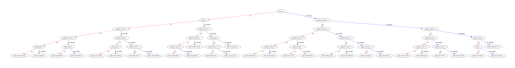

In [32]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
plt.figure(figsize=(25,25))
plot_tree(model, fontsize=24)
# plt.show()
plt.savefig('tree_high_dpi', dpi=1200)